# Python data analysis script
This script takes `.json` files exported from the `[JSONWriter]` module of Corryvreckan, and is aimed towards analyzing and plotting the hit data.

In [1]:
print('Importing packages...')
import json
import os
import numpy as np
from tqdm import tqdm

Importing packages...


## Importing data into python
### Reading in .json file

In [2]:
print('Loading File...')
file = 'data/example.json'

with open(file) as json_file:
    data = json.load(json_file)

Loading File...


The JSON file is structured as follows:

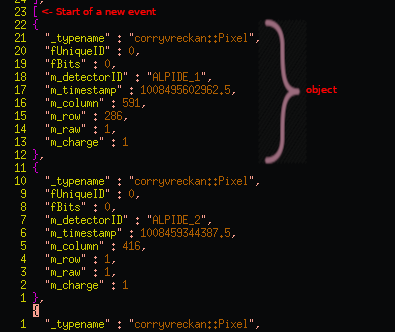

The information of a single pixel hit is stored inside of an object, and these objects are bundled into events.

### Writing all relevant data into one object
The goal of this section is to create a python object that contains all necessary data of all events. It should be able to be appended further down the line. The easiest way to do this is to use python lists and dictonaries.

In [3]:
hit_data = []    #initialize the list of all events
event_no = 0     #use a counter that will be incremented on each step

#Start the event loop
for event in data:
    
    #Skip over empty events
    if len(event) == 0: continue
        
    #Create a python dictionary for each event.
    hit_data.append({})
    
    #Create an entry in the dictionary for each plane
    for plane in range(7):
        hit_data[event_no][plane] = {}      #Stores all plane data
        hit_data[event_no][plane]["X"] = [] #Stores x-coordinates of hits
        hit_data[event_no][plane]["Y"] = [] #Stores y-coordinates of hits
    
    #Read out pixel by pixel
    for obj in event:
        
        #First, find out which plane the hit belongs to
        plane = int(obj["m_detectorID"].split("_")[1])
        #Second, read out x (column) and y (row) data
        hit_data[event_no][plane]["X"].append(int(obj["m_column"]))
        hit_data[event_no][plane]["Y"].append(int(obj["m_row"]))
        
    #Increment counter
    event_no+=1

For example, we can look at the 614th event like this:

In [4]:
hit_data[613]

{0: {'X': [768], 'Y': [150]},
 1: {'X': [591, 694, 695, 695, 694], 'Y': [286, 160, 160, 161, 161]},
 2: {'X': [692, 692], 'Y': [68, 69]},
 3: {'X': [699], 'Y': [39]},
 4: {'X': [506, 713, 713, 714, 714], 'Y': [372, 5, 6, 5, 6]},
 5: {'X': [708, 708], 'Y': [14, 15]},
 6: {'X': [], 'Y': []}}

## Masking
Some pixels on some planes have a high tendency to fire randomly. In this step, the goal is to find these pixels, and exclude them from our analysis.

In [5]:
print('Creating Mask...')

#Create a matrix for each plane
pixels = np.zeros((7,1024,512),int)

#Loop over all events
for event in range(len(hit_data)):
    
    #Loop over all planes
    for plane in range(7):
        
        #Check, how many hits the event contains
        nhits = len(hit_data[event][plane]['X'])
        
        #Increment the corresponding matrix element
        for hit in range(nhits):
            x = hit_data[event][plane]['X'][hit]
            y = hit_data[event][plane]['Y'][hit]
            pixels[plane][x][y]+=1

# Check for the mean hit rate of all pixels
frequency = []
for plane in range(7):
    for x in range(1024):
        for y in range(512):
            frequency.append(pixels[plane][x][y])
            
mean_hits = np.mean(frequency)

print('Pixels fired on average {} times'.format(
    np.round(mean_hits,2)))

#Then, mask all pixels that fire 100x more frequent
mask_limit = int(np.round(100*mean_hits))

print('Masking all pixels that fired more than {} times'.format(
    mask_limit))

#We will store them in a list for quick reference
masked_pixels = []

with tqdm(total=7*1024*512) as pbar:
    for plane in range(7):
        masked_pixels.append([])
        for x in range(1024):
            for y in range(512):
                pbar.update()
                if (pixels[plane][x][y] > mask_limit):
                    masked_pixels[plane].append((x,y))

print("Masked pixels:\n{}".format(masked_pixels))

Creating Mask...


  1%|▏         | 51179/3670016 [00:00<00:07, 511780.73it/s]

Pixels fired on average 0.07 times
Masking all pixels that fired more than 7 times


100%|██████████| 3670016/3670016 [00:05<00:00, 644219.95it/s]

Masked pixels:
[[], [(591, 286)], [(416, 1), (416, 4), (416, 7), (416, 10), (416, 12), (416, 13), (416, 14), (416, 16), (416, 19), (416, 25), (416, 28), (416, 31), (416, 36), (416, 40), (416, 47), (416, 48), (416, 49), (416, 50), (416, 51), (416, 52), (416, 56), (416, 57), (416, 58), (416, 61), (417, 2), (417, 3), (417, 4), (417, 7), (417, 18), (417, 21), (417, 23), (417, 24), (417, 25), (417, 26), (417, 28), (417, 29), (417, 34), (417, 37), (417, 44), (417, 47), (417, 48), (417, 50), (417, 51), (417, 52), (417, 57), (417, 63)], [(390, 398)], [(506, 372)], [], []]


We can see, for example, that plane 1, 6 and 7 do not have any hot pixels, while plane 3 has a whole double-column that continuously fires.

Now we see, that also our 614th event is affected by a hot pixel on `plane_1`. To fix all these events, we will remove all hits from those hot pixels:

In [6]:
#Save number of events before masking for later ;)
before_masking = len(hit_data)

for event in range(len(hit_data)):
    
    for plane in range(7):
        nhits = len(hit_data[event][plane]['X'])
        counter = 0
        for hit in range(nhits):
            x = hit_data[event][plane]['X'][counter]
            y = hit_data[event][plane]['Y'][counter]
            if (x,y) in masked_pixels[plane]:
                hit_data[event][plane]['X'].remove(x)
                hit_data[event][plane]['Y'].remove(y)
                counter-=1 #If an event is removed, check the next event that takes its place
            counter+=1
            
#Finally remove all empty events (reverse to avoid confusion)
for event in reversed(range(len(hit_data))):
    
    #First, assume the event is empty
    empty = True
    
    #Check all planes
    for plane in range(7):
        
        #If there is a hit, mark as non-empty
        if hit_data[event][plane]['X']:
            empty = False
            break
    
    #Then delete the event
    if empty: del hit_data[event]
        
after_masking = len(hit_data)

print('Reduced {} events to {} events after masking'.format(before_masking,after_masking))

Reduced 87375 events to 5249 events after masking


In [7]:
#The 614th event is now the 31st
hit_data[30]

{0: {'X': [768], 'Y': [150]},
 1: {'X': [694, 695, 695, 694], 'Y': [160, 160, 161, 161]},
 2: {'X': [692, 692], 'Y': [68, 69]},
 3: {'X': [699], 'Y': [39]},
 4: {'X': [713, 713, 714, 714], 'Y': [5, 6, 5, 6]},
 5: {'X': [708, 708], 'Y': [14, 15]},
 6: {'X': [], 'Y': []}}

### Adding some helpful information

For later analysis, it can come in handy, to seperate the events into different categories, based on the number of planes that have been hit. So we'll quickly add an entry for that.

Apart from that, in order to be able to loop over all events, no matter if there was a hit or not, we will need to add an identifier to the empty events. We chose `-1` for this, as it is easy to keep apart from an actual pixel hit.

In [8]:
for event in range(len(hit_data)):
    
    total_planes = 7 #Set the total number of planes
    
    for plane in range(total_planes):
        if not hit_data[event][plane]["X"]:        #for each empty event
            hit_data[event][plane]["X"].append(-1) #write a -1 into the hit array
            hit_data[event][plane]["Y"].append(-1) #---"---
            total_planes-=1                        #and substract one from the total number of planes
           
    #Add an entry into the dictionary
    hit_data[event]["number_of_planes"] = total_planes

In [24]:
#Function for counting n-plane events
def count(nop):
    counter = 0
    for i in range(len(hit_data)):
        if (hit_data[i]['number_of_planes'] == int(nop)): counter+=1
    print('{} {}-plane events found.'.format(counter,nop))
    return counter
count(7)

378 7-plane events found.


378

Now, our object will look like this:

In [10]:
hit_data[30]

{0: {'X': [768], 'Y': [150]},
 1: {'X': [694, 695, 695, 694], 'Y': [160, 160, 161, 161]},
 2: {'X': [692, 692], 'Y': [68, 69]},
 3: {'X': [699], 'Y': [39]},
 4: {'X': [713, 713, 714, 714], 'Y': [5, 6, 5, 6]},
 5: {'X': [708, 708], 'Y': [14, 15]},
 6: {'X': [-1], 'Y': [-1]},
 'number_of_planes': 6}

This way, we can add all sort of stuff into the dictionary as we go on, from tracking information, all the way to residuals and goodness-of-fit information.

## Calculating hit positions
For now, our data consisted of individual pixel hits. In the next step, we want to combine these hits into a cluster, to determine the hit position more accurately.

This will simply be done, by using the mean x and y coordinates of all pixel hits associated to one event, and their standard deviations.

In [11]:
print('Calculating hit positions...')

with tqdm(total=len(hit_data)) as pbar:

    for event in range(len(hit_data)):
    
        for plane in range(7):
        
            if (hit_data[event][plane]["X"][0] == -1):
                hit_data[event][plane]["XC"] = -1.0
                continue
                
            #Calculate the cluster position in X and Y (mean)
            Cluster_X = np.round(np.mean(hit_data[event][plane]["X"]),2)
            Cluster_Y = np.round(np.mean(hit_data[event][plane]["Y"]),2)
        
            #Calculate the standard deviation (the cluster spread)
            sdev = np.round(
                np.sqrt(
                    np.std(hit_data[event][plane]["X"])**2+
                    np.std(hit_data[event][plane]["Y"])**2),2)
        
            #If the cluster consists of one pixel alone, the uncertainty is defined by the binary resolution
            if sdev == 0:
                sdev = np.round(1/np.sqrt(12),2)
        
            #Add an entry to the dictionary
            hit_data[event][plane]["XC"] = Cluster_X
            hit_data[event][plane]["YC"] = Cluster_Y
            hit_data[event][plane]["sdev"] = sdev
                
        pbar.update(1)
                

  3%|▎         | 152/5249 [00:00<00:03, 1519.46it/s]

Calculating hit positions...


100%|██████████| 5249/5249 [00:03<00:00, 1562.01it/s]


Now, our object will contain a lot of new, helpful stuff!

In [12]:
hit_data[30]

{0: {'X': [768], 'Y': [150], 'XC': 768.0, 'YC': 150.0, 'sdev': 0.29},
 1: {'X': [694, 695, 695, 694],
  'Y': [160, 160, 161, 161],
  'XC': 694.5,
  'YC': 160.5,
  'sdev': 0.71},
 2: {'X': [692, 692], 'Y': [68, 69], 'XC': 692.0, 'YC': 68.5, 'sdev': 0.5},
 3: {'X': [699], 'Y': [39], 'XC': 699.0, 'YC': 39.0, 'sdev': 0.29},
 4: {'X': [713, 713, 714, 714],
  'Y': [5, 6, 5, 6],
  'XC': 713.5,
  'YC': 5.5,
  'sdev': 0.71},
 5: {'X': [708, 708], 'Y': [14, 15], 'XC': 708.0, 'YC': 14.5, 'sdev': 0.5},
 6: {'X': [-1], 'Y': [-1], 'XC': -1.0},
 'number_of_planes': 6}

## Taking a first look at the data

We will be using the `mplot3d` toolkit from `matplotlib` to visualize the data. First we import it:

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import proj3d
%matplotlib notebook

First of all, we need to convert from pixel into mm in order to be able to compare x and y position to z position.

In [14]:
#Define pixel pitches
ppx, ppy, ppz = 0.02924, 0.02688, 20 #Pixel pitches in x and y [mm]

Next we choose what data to plot, and how we want it to look like.

In [27]:
connect_hits = True         #Connects the hits
plot_tracks = False         #Plots Tracks (for later)

def plot(n,connect_hits,plot_tracks,min_nop):
    #Dimensions of the detector
    xlim = 1023*ppx
    ylim = 511*ppy
    zlim = 6*ppz

    #Create a figure object
    fig = plt.figure(figsize=(5,5))
    ax = plt.axes(projection='3d')    #Create 3d Axes
    ax._axis3don = False              #... but invisible
    #ax.set_box_aspect((3,3,3))       #Define aspect ratio (doesn't work in jupyter)
    ax.set_xlim3d(0,xlim)             #Axis limits in x
    ax.set_ylim3d(0,ylim)             #Axis limits in y
    ax.set_zlim3d(0,zlim)             #Axis limits in z
    x = np.arange(0,1025*ppx,512*ppx) #Create a meshgrid for plane-plotting
    y = np.arange(0,1024*ppy,512*ppy)
    X, Y = np.meshgrid(x,y)
    Z = np.ndarray((len(y),len(x)))
    Z.fill(0)

    #Draw the planes
    for plane in range(7):
        Z.fill(plane*ppz)
        ax.plot_surface(X,Y,Z,alpha=.1,color='black')

    plot_counter = 0 #We count the plots because we only want SOME
    #Plot the hits
    for event in range(len(hit_data)):

        #Plot only events with the minimum amount of planes specified
        if (hit_data[event]['number_of_planes'] < min_nop): continue
        print('Plotting event {}'.format(event))

        x_data, y_data, z_data = [], [], []

        for plane in range(7):

            #Skip over empty hits
            if (hit_data[event][plane]["XC"] == -1): continue

            #Put everything else into plottable arrays
            x_data.append(ppx*hit_data[event][plane]["XC"])
            y_data.append(ppy*hit_data[event][plane]["YC"])
            z_data.append(plane*ppz)

            ax.scatter3D(x_data,y_data,z_data,alpha=.7,color='black',marker='.')

            # OPTIONAL: Connect dots for Better visibility of Tracks
            if connect_hits:
                ax.plot(x_data,y_data,z_data, linewidth=.5)#, color='grey')
                
            # OPTIONAL: Plot tracks associated to events
            if plot_tracks:
                x_track = [hit_data[event]['Track_Point_1'][0],hit_data[event]['Track_Point_2'][0]]
                y_track = [hit_data[event]['Track_Point_1'][1],hit_data[event]['Track_Point_2'][1]]
                z_track = [hit_data[event]['Track_Point_1'][2],hit_data[event]['Track_Point_2'][2]]
                ax.plot(x_track,y_track,z_track,linewidth=.5)

        plot_counter+=1
        if plot_counter == n: break
    plt.show()

For example, we can plot 3 events where at least 6 planes were hit.

Plotting event 18
Plotting event 30
Plotting event 36


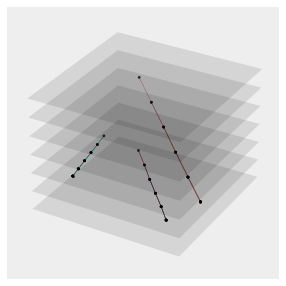

In [28]:
plot(3,connect_hits,plot_tracks,6)

## Tracking
In the next step, we'll investigate a way to approximate the data with 
tracks. Describing the data with tracks is a very useful concept that will later help us align the detector planes.

The first step is to approximate each event with a track. A track is a mathematical object, and is not limited to the resolution of the pixel matrix. It has a much higher accuracy than the hits themselves.

Secondly, we want to assign a value to each track, describing the goodness-of-fit to the track. This will be done with a residual (chi squared) analysis.

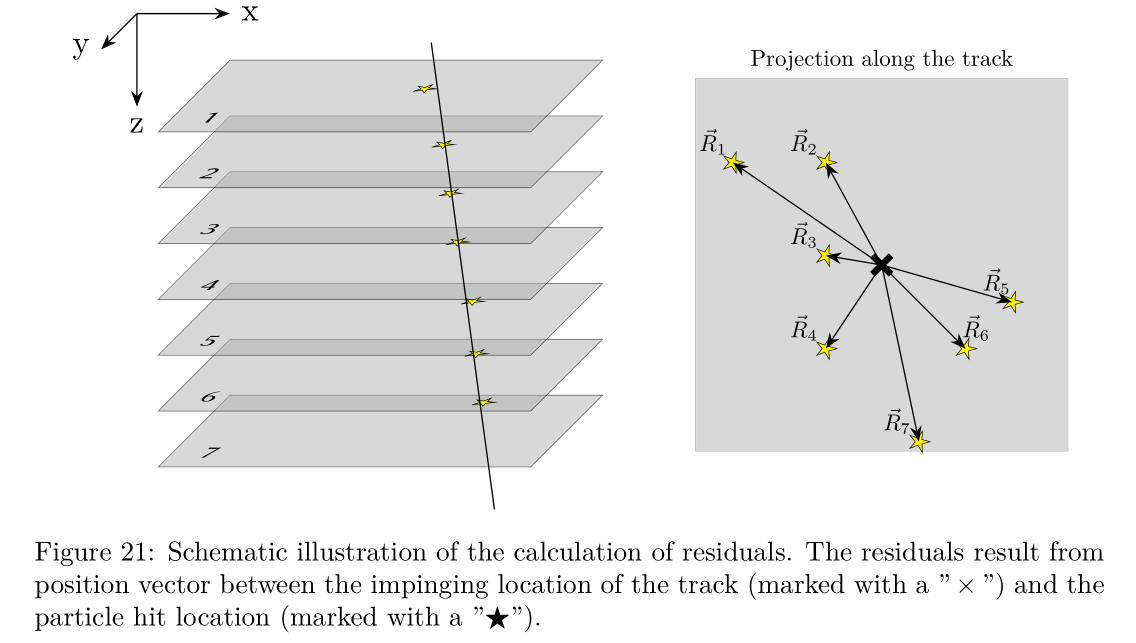

For an easier analysis, we will only calculate tracks for 4-or-more-plane events.

_Note: Through the introduction of the z-dimension, we now calculate in mm instead of pixels. This means, the track data will be in mm while the pixel hit positions are still described in pixels. So whenever calculations are done, the pixel hits have to be multiplied to the corresponding pixel pitch._

In [32]:
#Set the minimum requirement to 4 tracks (or higher, if you have the statistics)
min_nop = 4
print('Tracking...')
    
#Loop over all events
for event in range(len(hit_data)):

    #Number of planes belonging to the track
    nop = hit_data[event]["number_of_planes"]
    if nop < min_nop: continue

    #Create some arrays to calculate in (convert px to mm)
    Fit_Data = np.ndarray((nop,3))
    std_hit = np.ndarray((nop))
    planes_used = [] #This is to exclude empty planes later

    #Create a counter for the Fit Array
    counter = 0

    #Loop over all planes
    for plane in range(7):

        #Skip empty planes
        if (hit_data[event][plane]["XC"] == -1): continue

        #Note which planes are non-empty
        planes_used.append(plane)

        #Convert pixel lengths into mm
        Fit_Data[counter][0] = ppx*hit_data[event][plane]["XC"]
        Fit_Data[counter][1] = ppy*hit_data[event][plane]["YC"]
        Fit_Data[counter][2] = ppz*plane  
        std_hit[counter] = np.sqrt((ppx**2+ppy**2)/2)*hit_data[event][plane]["sdev"]
        counter+=1

    # Fitting Algorithm (Based on np.linalg.svd)
    datamean = Fit_Data.mean(axis=0)
    uu, dd, vv = np.linalg.svd(Fit_Data - datamean)
    linepts = vv[0] * np.mgrid[-100:100:2j][:,np.newaxis]
    linepts += datamean

    # Two Points Define the Fitted Track
    x1 = linepts[0]
    x2 = linepts[1]

    # Take the residual
    d = []
    for plane in planes_used:
        x0 = np.array([
            hit_data[event][plane]["XC"]*ppx,
            hit_data[event][plane]["YC"]*ppy,
            plane*ppz])

        # Solve for the point in plane of Track (simply z = a+mb)
        lbda = (x0[2] - x2[2])/(x2-x1)[2] # m = (z-a)/(b)
        xz = x2+lbda*(x2-x1) # find point in axis that lies in the same plane
        hit_data[event][plane]["resx"] = (x0-xz)[0]
        hit_data[event][plane]["resy"] = (x0-xz)[1]
        d.append(np.linalg.norm(xz-x0))

    #Add an entry into the dictionary containing the track coordinates
    hit_data[event]["Track_Point_1"], hit_data[event]["Track_Point_2"] = [],[]
    for i in range(3):
        hit_data[event]["Track_Point_1"].append(x1[i])
        hit_data[event]["Track_Point_2"].append(x2[i])

    # From there, calculate chi2 to determine the goodness of the fit
    chi2 = 0
    for entry in range(len(d)):
        chi2 += d[entry]**2/std_hit[entry]**2

    hit_data[event]["chi2"] = chi2
    #Also add an entry for reduced chi2
    hit_data[event]["chi2red"] = chi2/(nop*3-4)

print('Done!')

Tracking...
Done!


Now, our object contains also Track data:

Plotting event 63
Plotting event 88
Plotting event 101


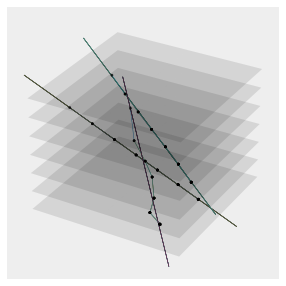

In [33]:
plot(3,True,True,7)

## Quality of fits

To analyse fit quality, we can take a look at the chi squared distribution

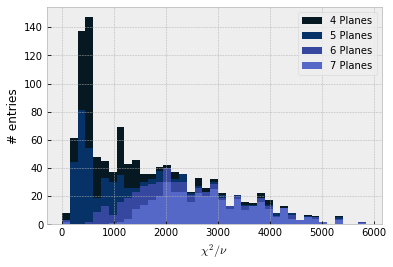

In [19]:
plt.style.use('bmh')

def plotchi2(chi2_cut,number_of_bins):
    chi2_7 = []
    chi2_6 = []
    chi2_5 = []
    chi2_4 = []
    for i in range(len(hit_data)):
        if hit_data[i]['number_of_planes'] < 4: continue
        if hit_data[i]['chi2red'] >= chi2_cut: continue
        if (hit_data[i]['number_of_planes'] == 7):
            chi2_7.append(hit_data[i]['chi2red'])
            chi2_6.append(hit_data[i]['chi2red'])
            chi2_5.append(hit_data[i]['chi2red'])
            chi2_4.append(hit_data[i]['chi2red'])
        elif (hit_data[i]['number_of_planes'] == 6):
            chi2_6.append(hit_data[i]['chi2red'])
            chi2_5.append(hit_data[i]['chi2red'])
            chi2_4.append(hit_data[i]['chi2red'])
        elif (hit_data[i]['number_of_planes'] == 5):
            chi2_5.append(hit_data[i]['chi2red'])
            chi2_4.append(hit_data[i]['chi2red'])
        elif (hit_data[i]['number_of_planes'] == 4):
            chi2_4.append(hit_data[i]['chi2red'])

    plt.hist(chi2_4,number_of_bins,color='#061822',label='4 Planes')
    plt.hist(chi2_5,number_of_bins,color='#063268',label='5 Planes')
    plt.hist(chi2_6,number_of_bins,color='#3647a0',label='6 Planes')
    plt.hist(chi2_7,number_of_bins,color='#5668c7',label='7 Planes')
    plt.xlabel(r'$\chi^2/\nu$')
    plt.ylabel('# entries')
    plt.legend()
    plt.plot()
    
plotchi2(6000,np.arange(0,6000,150))

As you can see, the fit quality is very bad. This is because the planes have a relative offset to one another, which will add a deviation to each track.

In order to fix this, we have to somehow quantify the plane offsets. **Now, the residuals we calculated earlier come in handy!** A residual is the distance between pixel hit and track intercept on each plane. Ideally, we would like to see the chi2red distribution peak at around 1.

### Residuals
The residuals serve as a direct measurement of the plane offset. Each plane should have a peak in its residual distribution

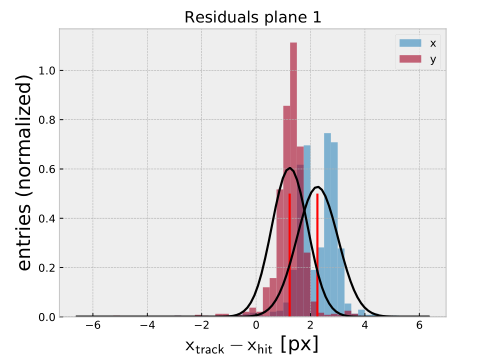

To align the telescope, all we need to do is shift these residuals to 0!

To make sure to have an unbiased result (the shearing bias is described in more detail
in my [bachelor thesis](https://www.physi.uni-heidelberg.de/Publications/M_Donner_BachelorThesis.pdf)), we need to define two planes as
fixed, and then iteratively align the other 5 planes. For simplicity reasons, we will chose plane 0 and 7 for this.

## Alignment

This is where the magic happens. As we learned, each plane has a slight offset, which can clearly be seen in the data. To correct for this, we will iteratively calculate the residuals for each track, take the arithmetic mean, and fix the position of the telescope virtually.

**TODO**:
Things to keep in mind
- Chi2 cut
- coarse alignments and fine alignments

Starting Alignment procedure...
Tracking...
Calculating Residuals...
1248 Tracks survived the chi2 cut of 199526.2314968879
Offset plane 0: x = 0 y = 0
Offset plane 1: x = -0.4889 y = 0.9014
Offset plane 2: x = -0.3246 y = -0.3403
Offset plane 3: x = -0.1592 y = -0.2157
Offset plane 4: x = -0.0247 y = -0.393
Offset plane 5: x = -0.3895 y = 0.5266
Offset plane 6: x = 0 y = 0
Tracking...
Calculating Residuals...
1248 Tracks survived the chi2 cut of 154790.24575053767
Offset plane 0: x = 0 y = 0
Offset plane 1: x = -0.2712 y = 0.1718
Offset plane 2: x = -0.2474 y = -0.0427
Offset plane 3: x = -0.2054 y = -0.0778
Offset plane 4: x = -0.1769 y = -0.0262
Offset plane 5: x = -0.1557 y = 0.0384
Offset plane 6: x = 0 y = 0
Tracking...
Calculating Residuals...
1248 Tracks survived the chi2 cut of 120084.56231423141
Offset plane 0: x = 0 y = 0
Offset plane 1: x = -0.1964 y = 0.0364
Offset plane 2: x = -0.2065 y = -0.0055
Offset plane 3: x = -0.1934 y = -0.02
Offset plane 4: x = -0.1554 y = -0.013

Calculating Residuals...
1105 Tracks survived the chi2 cut of 450.6570337745473
Offset plane 0: x = 0 y = 0
Offset plane 1: x = -0.0073 y = -0.0026
Offset plane 2: x = -0.0078 y = -0.0031
Offset plane 3: x = -0.0077 y = -0.0031
Offset plane 4: x = -0.0067 y = -0.0023
Offset plane 5: x = -0.0052 y = -0.0013
Offset plane 6: x = 0 y = 0
Tracking...
Calculating Residuals...
1100 Tracks survived the chi2 cut of 349.61474731335517
Offset plane 0: x = 0 y = 0
Offset plane 1: x = -0.005 y = -0.0036
Offset plane 2: x = -0.0065 y = -0.0027
Offset plane 3: x = -0.007 y = -0.003
Offset plane 4: x = -0.0047 y = -0.0022
Offset plane 5: x = -0.0043 y = -0.0013
Offset plane 6: x = 0 y = 0
Tracking...
Calculating Residuals...
1092 Tracks survived the chi2 cut of 271.2272579332027
Offset plane 0: x = 0 y = 0
Offset plane 1: x = -0.0061 y = -0.0017
Offset plane 2: x = -0.0038 y = -0.0025
Offset plane 3: x = -0.0046 y = -0.0032
Offset plane 4: x = -0.0041 y = -0.0023
Offset plane 5: x = -0.0033 y = -0.000

Fine Alignment iteration 9
Calculating Residuals...
993 Tracks survived the chi2 cut of 10.0
Offset plane 0: x = 0 y = 0
Offset plane 1: x = -0.0004 y = -0.0003
Offset plane 2: x = -0.0004 y = -0.0004
Offset plane 3: x = -0.0004 y = -0.0004
Offset plane 4: x = -0.0003 y = -0.0003
Offset plane 5: x = -0.0003 y = -0.0002
Offset plane 6: x = 0 y = 0
Tracking...
Fine Alignment iteration 10
Calculating Residuals...
993 Tracks survived the chi2 cut of 10.0
Offset plane 0: x = 0 y = 0
Offset plane 1: x = -0.0003 y = -0.0003
Offset plane 2: x = -0.0004 y = -0.0003
Offset plane 3: x = -0.0004 y = -0.0003
Offset plane 4: x = -0.0003 y = -0.0003
Offset plane 5: x = -0.0002 y = -0.0002
Offset plane 6: x = 0 y = 0
Plane 0 X: 0 +- 0.02
Plane 0 Y: 0 +- 0.02
Plane 1 X: -2.1 +- 0.01
Plane 1 Y: 1.07 +- 0.03
Plane 2 X: -2.08 +- 0.02
Plane 2 Y: -0.54 +- 0.01
Plane 3 X: -1.78 +- 0.01
Plane 3 Y: -0.5 +- 0.02
Plane 4 X: -1.32 +- 0.01
Plane 4 Y: -0.61 +- 0.02
Plane 5 X: -1.39 +- 0.01
Plane 5 Y: 0.47 +- 0.01
P

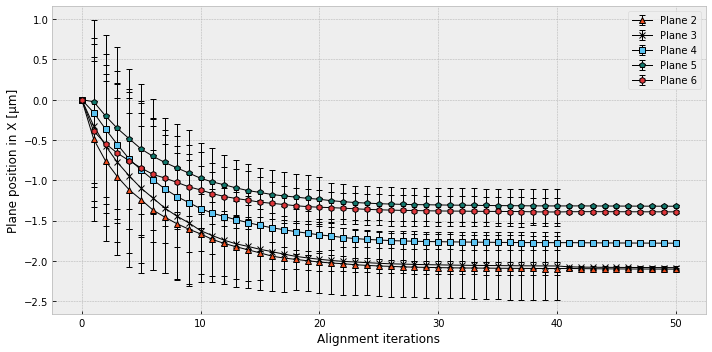

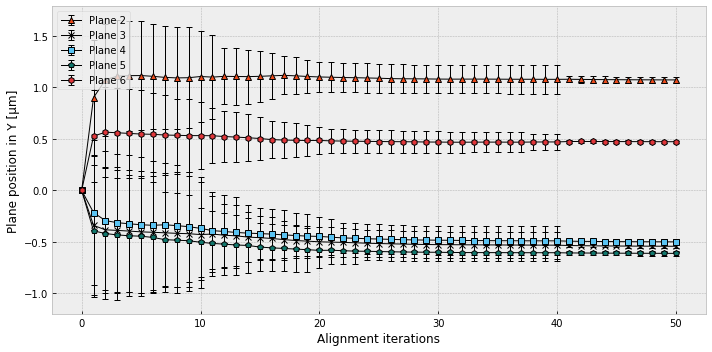

In [20]:
planes_used = [0,6]   #Planes fixed for alignment
alignments = 50       #Number of alignment steps (~50 recommended)
fine_alignments = 10  #Number of fine alignment steps (~10 recommended)
plot_each_step = False #Debugging
chi2_cut = np.logspace(5.3,1,alignments-fine_alignments)
min_chi2_reached = False

min_nop = 4
N = len(hit_data) # Number of events (hardcoded for now)
ppx, ppy, ppz = 0.02924, 0.02688, 20
cnt = 0

# Initialize list for plotting alignment progress
posx, posy, dposx, dposy = [], [], [], []
for i in range(7):
    posx.append([])
    posy.append([])
    dposx.append([])
    dposy.append([])
    posx[i].append(0)
    posy[i].append(0)
    dposx[i].append(0)
    dposy[i].append(0)

print('Starting Alignment procedure...')

for a in range(alignments):

    print('Tracking...')

    # Count how many tracks are used for alignment after chi2cut
    cnt_track = 0

    # Show chi2 distro (debugging)
    chi2_array = []

    for track in range(N):

        # Number of planes belonging to the track
        nop = hit_data[track]["number_of_planes"]
        if nop < min_nop: continue

        # Fix Offset of planes_used to be 0
        plane1, plane2 = planes_used[0], planes_used[1]
        posx[plane1][a], posy[plane1][a] = 0, 0
        posx[plane2][a], posy[plane2][a] = 0, 0

        # Apply alignment for the planes
        for plane in range(7):
            if (hit_data[track][plane]["XC"] == -1): continue
            hit_data[track][plane]["XC"]-=posx[plane][a]/ppx #TAKE CARE! convert back to pixels
            hit_data[track][plane]["YC"]-=posy[plane][a]/ppy # --- "" ---
        
        # Convert pixel into mm
        Fit_Data = np.zeros((nop,3))
        tracked_planes = []
        count_planes = 0
        for plane in range(7):
            if (hit_data[track][plane]["XC"] == -1): continue
            tracked_planes.append(plane)
            Fit_Data[count_planes][0] = ppx*hit_data[track][plane]["XC"]
            Fit_Data[count_planes][1] = ppy*hit_data[track][plane]["YC"]
            Fit_Data[count_planes][2] = ppz*plane
            count_planes+=1
        
        # Fitting Algorithm
        datamean = Fit_Data.mean(axis=0)
        uu, dd, vv = np.linalg.svd(Fit_Data - datamean)
        linepts = vv[0] * np.mgrid[-100:100:2j][:,np.newaxis]
        linepts += datamean

        # Two Points Define the Fitted Track
        x1 = linepts[0]
        x2 = linepts[1]

        # Calculate the residuals for all planes
        d = []
        std_hit = []
        for plane in tracked_planes:
            x0 = np.array([
                ppx*hit_data[track][plane]["XC"],
                ppy*hit_data[track][plane]["YC"],
                ppz*plane])
            # Solve for the point in plane of Track z = a+mb
            lbda = (x0[2] - x2[2])/(x2-x1)[2] # m = (z-a)/(b)
            xz = x2+lbda*(x2-x1) # find point in axis that lies in the same plane
            hit_data[track][plane]["resx"] = (x0-xz)[0]
            hit_data[track][plane]["resy"] = (x0-xz)[1]
            std_hit.append(np.sqrt((ppx**2+ppy**2)/2)*hit_data[track][plane]["sdev"])
            d.append(np.linalg.norm(xz-x0))

        #Add an entry into the dictionary containing the track coordinates
        hit_data[track]["Track_Point_1"], hit_data[track]["Track_Point_2"] = [],[]
        for i in range(3):
            hit_data[track]["Track_Point_1"].append(x1[i])
            hit_data[track]["Track_Point_2"].append(x2[i])

        # From there, calculate chi2 to determine the goodness of the fit
        chi2 = 0
        for entry in range(len(d)):
            chi2 += d[entry]**2/std_hit[entry]**2
        hit_data[track]["chi2"] = chi2
        hit_data[track]["chi2red"] = chi2/(nop*3-4)

        # Plot distro (DEBUG??)
        if chi2/(nop*3-4) <= chi2_cut[cnt]:
            chi2_array.append(chi2)

    # Create Dictionary for Residuals
    Res = {}
    for plane in range(7):
        Res[plane] = {}
        Res[plane]['x'] = []
        Res[plane]['y'] = []

    if min_chi2_reached:
        print('Fine Alignment iteration {}'.format(a-alignments+fine_alignments+1))

    # Fill Residual Dictionary
    print('Calculating Residuals...')
    for track in range(N):
        nop = hit_data[track]["number_of_planes"]
        if nop < min_nop: continue
        if (hit_data[track]['chi2red'] >= chi2_cut[cnt]): continue
        cnt_track+=1

        # After minimum chi2red is reached
        if min_chi2_reached:
            for plane in range(7):
                if (hit_data[track][plane]['XC'] == -1): continue
                if (abs(hit_data[track][plane]['resx']) <= 10*ppx): # To avoid faraway residuals
                    Res[plane]['x'].append(hit_data[track][plane]['resx'])
                if (abs(hit_data[track][plane]['resy']) <= 10*ppy):
                    Res[plane]['y'].append(hit_data[track][plane]['resy'])

        # Before min chi2 is reached
        else:
            for plane in range(7):
                if (hit_data[track][plane]['XC'] == -1): continue
                Res[plane]['x'].append(hit_data[track][plane]['resx'])
                Res[plane]['y'].append(hit_data[track][plane]['resy'])

    if plot_each_step:
        plt.hist(chi2_array,40)
        plt.show()

    # Calculate mean of residual
    OffsetX, OffsetY, dOffsetX, dOffsetY = [], [], [], []
    for plane in range(7):
        if plane in planes_used:
            OffsetX.append(0)
            OffsetY.append(0)
            dOffsetX.append(np.std(Res[plane]['x']))
            dOffsetY.append(np.std(Res[plane]['y']))
            continue
        OffsetX.append(np.mean(Res[plane]['x']))
        OffsetY.append(np.mean(Res[plane]['y']))
        dOffsetX.append(np.std(Res[plane]['x']))
        dOffsetY.append(np.std(Res[plane]['y']))

    # Append changes to position array
    print('{} Tracks survived the chi2 cut of {}'.format(cnt_track,chi2_cut[cnt]))
    if cnt_track <= 200: print('WARNING!!! CHI2 CUT MIGHT BE TOO STRONG')

    for plane in range(7):
        print("Offset plane {}: x = {} y = {}".format(
            plane,np.round(OffsetX[plane],4),np.round(OffsetY[plane],4)))
        posx[plane].append(OffsetX[plane])
        posy[plane].append(OffsetY[plane])
        dposx[plane].append(dOffsetX[plane])
        dposy[plane].append(dOffsetY[plane])

    # increment counter for chi2 cut
    if (cnt < len(chi2_cut)-1):
        cnt+=1
    else: min_chi2_reached = True

# So far, only the offsets have been written to posx... need to append instead...
for a in range(alignments):
    for plane in range(7):
        posx[plane][a+1]+=posx[plane][a]
        posy[plane][a+1]+=posy[plane][a]

for plane in range(7):
    print('Plane {} X: {} +- {}'.format(
        plane,np.round(posx[plane][alignments],2),np.round(dposx[plane][alignments],2)))
    print('Plane {} Y: {} +- {}'.format(
        plane,np.round(posy[plane][alignments],2),np.round(dposy[plane][alignments],2)))

# Plot section {{{
print('Plotting...')
markers=['o','^','x','s','p','h','D']
col=['#fbcf36','#ed4c1c','#9c7e70','#5ac2f1','#11776c','#e0363a','#6a1c10']
xaxis = np.arange(alignments+1)
plt.figure(figsize=(10,5))
plt.xlabel('Alignment iterations')
plt.ylabel('Plane position in X [μm]')
#plt.ylim(-1000,400)
for plane in range(7):
    if plane in planes_used: continue
    plt.errorbar(xaxis,posx[plane],yerr=dposx[plane], label='Plane {}'.format(plane+1),
            linewidth=1,marker=markers[plane],color='black',capsize=3,mfc=col[plane])
plt.legend()
plt.tight_layout()

plt.figure(figsize=(10,5))
plt.xlabel('Alignment iterations')
plt.ylabel('Plane position in Y [μm]')
#plt.ylim(-1200,600)
for plane in range(7):
    if plane in planes_used: continue
    plt.errorbar(xaxis,posy[plane],yerr=dposy[plane], label='Plane {}'.format(plane+1),
            linewidth=1,marker=markers[plane],color='black',capsize=3,mfc=col[plane])
plt.legend()
plt.tight_layout()
plt.show()
# }}}

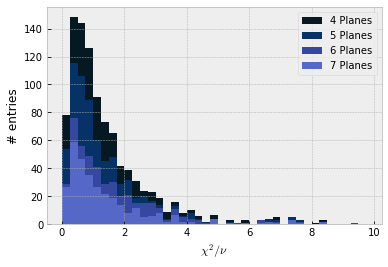

In [21]:
plotchi2(10,np.arange(0,10,.25))

Plotting event 63
Plotting event 88
Plotting event 101
Plotting event 125
Plotting event 137
Plotting event 157
Plotting event 168
Plotting event 185
Plotting event 241
Plotting event 247


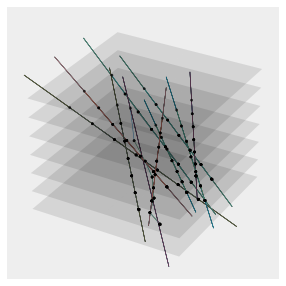

In [22]:
plot(10,True,True,7)